# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

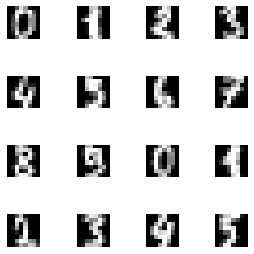

In [3]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4,4,figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4*i+j],(8,8))
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].axis('off')

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [4]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
  
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [5]:
#=========
# GRADING:
# 0 
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
#=========
# Implement a neural network (NN) classifier. 
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction='none') #it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Return the indexes with the highest probability which
        # are equivalent to the class labels because the labels are digits
        return torch.argmax(self.classnet(x), axis=1)

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        # calculate the negative log likelihood loss based on the target values y
        # and how the classifier network classifies data x
        loss = self.nll(self.classnet(x), y.type(torch.LongTensor))
        
        if reduction == 'sum':
            return loss.sum()
        return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:** <em>The objective is to minimize the negative log likelihood loss. The nn.NLLLoss is the function being minimized. The Negative log likelihood function looks like $-\log\textbf{y}$ where $\textbf{y}$ is the probability assigned to the correct label by the classifier. If the value of $\textbf{y}$ is close to $1$, then $-\log\textbf{y}$ will be a small positive number but if the value of $\textbf{y}$ is close to 0, then the value $-\log\textbf{y}$ will be very large because it approaches $\infty$ as $\textbf{y}$ approaches $0$. Thus the further away from the correct classification, the greater the loss and the steeper the gradient. The reduction of the negative log likelihood loss comes into play when dealing with batches. It tells the function what to do with the multiple loss values corresponding to each instance in the batch. If reduction is average, then the loss is the mean of every loss value. Similarly if reduction is summation, then the loss values get added together.</em>

<em>Technically, the nn.NLLLoss is not the $-\log\textbf{y}$ function itself as the $\log$ of softmax is already taken by the neural network so it really only takes the negative and selects which $\log$ probability to use based on the target value but that is semantically equivalent to the above.</em>

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** <em>Yes, it is fine because the logarithm does not change the most probable label, it changes only the probability to the log-probability.</em>

### 2.2 Evaluation

In [6]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None, print_freq=10):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + '.model')
  
    model_best.eval()# set the model to the evaluation mode
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
    else:
        if epoch % print_freq == 0:
            print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')

    return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='nll', color='b-', test_eval=None):
    # plot the curve
    plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel +' test')
        plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches='tight')
    plt.show()

### 2.3 Training procedure

In [7]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, print_freq=10):
    nll_val = []
    error_val = []
    best_nll = 1000.
    patience = 0
    
    # Evaluate model before training to show improvement
    loss_e, error_e = evaluation(val_loader, model_best=model, epoch=0, print_freq=print_freq)
    nll_val.append(loss_e)  # save for plotting
    error_val.append(error_e)  # save for plotting
    
    # Main training loop
    for e in range(num_epochs):
        model.train() # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e+1, print_freq=print_freq)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no 
        # progress is observed.
        if e == 0:
            torch.save(model, name + '.model')
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + '.model')
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [8]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
print("How do we get our data from Digits class? \n")
print(f"Feature example:\n{train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example:
[ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [10]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1,8,8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [11]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64   # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10 # the number of labels
num_kernels = 32 # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=2.3025425938197546, val ce=0.8942857142857142
Epoch: 10, val nll=0.32163558687482563, val ce=0.09428571428571429
Epoch: 20, val nll=0.1509117249080113, val ce=0.045714285714285714
Epoch: 30, val nll=0.12598201479230609, val ce=0.037142857142857144
Epoch: 40, val nll=0.1121320172718593, val ce=0.045714285714285714
Epoch: 50, val nll=0.09828727500779288, val ce=0.037142857142857144
Epoch: 60, val nll=0.09740724648748125, val ce=0.037142857142857144
Epoch: 70, val nll=0.09897751007761274, val ce=0.04
-> FINAL PERFORMANCE: nll=0.3479502206414071, ce=0.08053691275167785


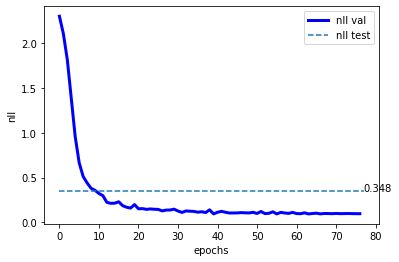

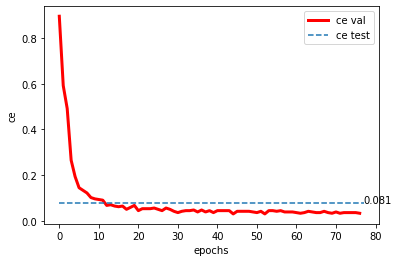


-> START classifier_cnn
Epoch: 0, val nll=2.383944854736328, val ce=0.9771428571428571
Epoch: 10, val nll=0.13039556060518537, val ce=0.02857142857142857
Epoch: 20, val nll=0.09668506741523743, val ce=0.02857142857142857
Epoch: 30, val nll=0.084448350582804, val ce=0.025714285714285714
Epoch: 40, val nll=0.07470688428197589, val ce=0.017142857142857144
Epoch: 50, val nll=0.07176327569144113, val ce=0.02
Epoch: 60, val nll=0.06655765801668168, val ce=0.014285714285714285
Epoch: 70, val nll=0.06758410764592035, val ce=0.017142857142857144
Epoch: 80, val nll=0.06448670203132288, val ce=0.014285714285714285
Epoch: 90, val nll=0.06454947508871556, val ce=0.014285714285714285
Epoch: 100, val nll=0.06219201181083918, val ce=0.014285714285714285
Epoch: 110, val nll=0.06268394476334964, val ce=0.014285714285714285
Epoch: 120, val nll=0.06268388640401619, val ce=0.014285714285714285
Epoch: 130, val nll=0.06045703096315265, val ce=0.014285714285714285
Epoch: 140, val nll=0.06050703554813351, val

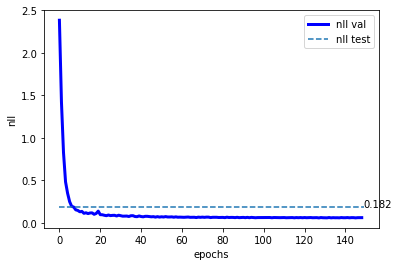

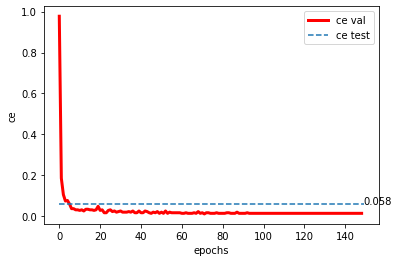

In [12]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = [
         'classifier_mlp',
         'classifier_cnn']

# loop over models
for name in names:
    print('\n-> START {}'.format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == 'classifier_mlp':
        name = name + '_M_' + str(M)
    elif name == 'classifier_cnn':
        name = name + '_M_' + str(M) + '_kernels_' + str(num_kernels)
  
    # Create a folder if necessary
    result_dir = os.path.join('results', name + '\\')
    if not(os.path.exists(result_dir)):
        os.makedirs(result_dir)

    # MLP
    if name[0:14] == 'classifier_mlp':
        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        
        # Create a sequential network with 4 hidden layers
        # Activations between every layer are ReLU for their quick
        # computations and non-vanishing gradients
        # Since no dying neurons have occurred there is no need to switch
        # to leaky ReLU
        # The final activation is log of softmax which is required by nn.NLLLoss
        classnet = nn.Sequential(
                    nn.Linear(D, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Linear(32, K),
                    nn.LogSoftmax(dim=1))
        
    # CNN
    elif name[0:14] == 'classifier_cnn':
        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        
        # Create a sequential network with convolutional and pooling
        # layers first and fully connected layers after
        # Before the netowrk can process the images it has to reshape the data
        # so the very first layer reshapes
        # Afterwards the convolutional and pooling layers extract features and
        # the fully connected layers learn from these features
        classnet = nn.Sequential(
                    Reshape(size=(1, 8, 8)),
                    nn.Conv2d(1, 16, 3, stride=1, padding='same'),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(16, 64, 3, stride=1, padding='same'),
                    nn.MaxPool2d(2, stride=2),
                    Flatten(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, K),
                    nn.LogSoftmax(dim=1))

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

    # Training procedure
    nll_val, error_val = training(name=result_dir + name,
                                  max_patience=max_patience,
                                  num_epochs=num_epochs,
                                  model=model,
                                  optimizer=optimizer,
                                  training_loader=training_loader,
                                  val_loader=val_loader)
  
    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + '_test_loss.txt', "w")
    f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
    f.close()
    # create curves
    plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
    plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: PLEASE FILL IN and PASTE THE IMAGES HERE

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: PLEASE FILL IN and PASTE THE IMAGES HERE

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

### Dataset

In [13]:
class Numbers(Dataset):
    THRESHOLD = 543949 # Used for seperating training data from validation data
    
    def __init__(self, mode='train', transforms=None):
        self.data, self.targets = self.get_data_and_targets(mode)
        self.transforms = transforms
    
    # Method for getting data based on mode
    def get_data_and_targets(self, mode):
        start, stop = None, None
        if mode == 'train':
            paths = [
                "SVHN dataset\\train.mat",
                "SVHN dataset\\extra.mat"
            ]
            stop = THRESHOLD
        elif mode == 'val':
            paths = [
                "SVHN dataset\\train.mat",
                "SVHN dataset\\extra.mat"
            ]
            start = THRESHOLD
        else:
            paths = ["SVHN dataset\\test.mat"]
        return self.load_from_paths(paths, start=start, stop=stop)    
    
    def load_from_paths(self, paths, start=None, stop=None):
        X, y = [], []
        for path in paths:
            mat = scipy.io.loadmat(path)
            X.append(mat['X'])
            y.append(mat['y'])
        X = np.concatenate(X, axis=-1)
        y = np.concatenate(y).reshape(-1)
        X, y = self.shuffle(X, y, seed=0)
        return X[:,:,:,start:stop], y[start:stop]
    
    @staticmethod
    def shuffle(data, target, seed=None):
        size = target.size
        if seed is not None: np.random.seed(seed)
        ind = np.random.choice(range(size), size, replace=False)
        return data[:,:,:,ind], target[ind]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        sample_x = np.moveaxis(self.data[:,:,:,idx], -1, 0).astype(np.float32)
        sample_y = self.targets[idx]%10
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

### Loading data

In [14]:
train_data = Numbers(mode="train")
val_data = Numbers(mode='val')
test_data = Numbers(mode='test')

training_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

NameError: name 'THRESHOLD' is not defined

### Data visualistation
Used to check that the data is loaded properly

In [ ]:
index = 0 # Index can be set to any integer in range [0, 543948]
imgs = train_data.__getitem__(index)
cmaps = ['Reds', 'Greens', 'Blues']

_, axs = plt.subplots(1, 3, figsize=(16, 4))

# Create an image for every RGB color channel
for ax, img, cmap in zip(axs, imgs[0], cmaps):
    ax.imshow(img, cmap=cmap)
plt.suptitle(f"Label: {imgs[1]}", fontsize=20)
plt.show()

### Running the model

### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
C = 3   # input channels

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10 # the number of labels
num_kernels = 32 #the number of kernels for CNN

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 100 # max. number of epochs
max_patience = 3 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
print('-> START training')

classnet = nn.Sequential(
            nn.Conv2d(C, 8, 3, stride=1, padding='same'),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 32, 3, stride=1, padding='same'),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=1, padding='same'),
            nn.MaxPool2d(2, stride=2),
            Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, K),
            nn.LogSoftmax(dim=0))

# Init ClassifierNN
model = ClassifierNeuralNet(classnet)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

# Training procedure
nll_val, error_val = training(name=result_dir + name,
                              max_patience=max_patience,
                              num_epochs=num_epochs,
                              model=model,
                              optimizer=optimizer,
                              training_loader=training_loader,
                              val_loader=val_loader,
                              print_freq=2)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
# f = open(result_dir + name + '_test_loss.txt', "w")
# f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
# f.close()
# create curves
plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)